In [1]:
import tensorflow as tf
import numpy as np
import cv2
import os
import pandas as  pd
import time
import matplotlib.pyplot as plt

2024-11-25 11:23:28.946471: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1732514008.963946 1642860 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1732514008.969345 1642860 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-25 11:23:28.986624: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
class_dict_df = pd.read_csv("/home/pranav/DeepLearning/semantic_drone_dataset/training_set/gt/semantic/class_dict.csv", index_col=False, skipinitialspace=True)
print(class_dict_df["name"])


0       unlabeled
1      paved-area
2            dirt
3           grass
4          gravel
5           water
6           rocks
7            pool
8      vegetation
9            roof
10           wall
11         window
12           door
13          fence
14     fence-pole
15         person
16            dog
17            car
18        bicycle
19           tree
20      bald-tree
21      ar-marker
22       obstacle
23    conflicting
Name: name, dtype: object


In [5]:
label_names= list(class_dict_df.name)
label_codes = []
r= np.asarray(class_dict_df.r)
g= np.asarray(class_dict_df.g)
b= np.asarray(class_dict_df.b)

for i in range(len(class_dict_df)):
    label_codes.append(tuple([r[i], g[i], b[i]]))
    
label_codes[:5], label_names[:5]

([(np.int64(0), np.int64(0), np.int64(0)),
  (np.int64(128), np.int64(64), np.int64(128)),
  (np.int64(130), np.int64(76), np.int64(0)),
  (np.int64(0), np.int64(102), np.int64(0)),
  (np.int64(112), np.int64(103), np.int64(87))],
 ['unlabeled', 'paved-area', 'dirt', 'grass', 'gravel'])

In [6]:
label_codes, label_names

([(np.int64(0), np.int64(0), np.int64(0)),
  (np.int64(128), np.int64(64), np.int64(128)),
  (np.int64(130), np.int64(76), np.int64(0)),
  (np.int64(0), np.int64(102), np.int64(0)),
  (np.int64(112), np.int64(103), np.int64(87)),
  (np.int64(28), np.int64(42), np.int64(168)),
  (np.int64(48), np.int64(41), np.int64(30)),
  (np.int64(0), np.int64(50), np.int64(89)),
  (np.int64(107), np.int64(142), np.int64(35)),
  (np.int64(70), np.int64(70), np.int64(70)),
  (np.int64(102), np.int64(102), np.int64(156)),
  (np.int64(254), np.int64(228), np.int64(12)),
  (np.int64(254), np.int64(148), np.int64(12)),
  (np.int64(190), np.int64(153), np.int64(153)),
  (np.int64(153), np.int64(153), np.int64(153)),
  (np.int64(255), np.int64(22), np.int64(96)),
  (np.int64(102), np.int64(51), np.int64(0)),
  (np.int64(9), np.int64(143), np.int64(150)),
  (np.int64(119), np.int64(11), np.int64(32)),
  (np.int64(51), np.int64(51), np.int64(0)),
  (np.int64(190), np.int64(250), np.int64(190)),
  (np.int64(11

In [7]:
code2id = {v:k for k,v in enumerate(label_codes)}
id2code = {k:v for k,v in enumerate(label_codes)}

name2id = {v:k for k,v in enumerate(label_names)}
id2name = {k:v for k,v in enumerate(label_names)}

In [8]:
def rgb_to_onehot(rgb_image, colormap = id2code):
    '''Function to one hot encode RGB mask labels
        Inputs: 
            rgb_image - image matrix (eg. 256 x 256 x 3 dimension numpy ndarray)
            colormap - dictionary of color to label id
        Output: One hot encoded image of dimensions (height x width x num_classes) where num_classes = len(colormap)
    '''
    num_classes = len(colormap)
    shape = rgb_image.shape[:2]+(num_classes,)
    encoded_image = np.zeros( shape, dtype=np.int8 )
    for i, cls in enumerate(colormap):
        encoded_image[:,:,i] = np.all(rgb_image.reshape( (-1,3) ) == colormap[i], axis=1).reshape(shape[:2])
    return encoded_image


def onehot_to_rgb(onehot, colormap = id2code):
    '''Function to decode encoded mask labels
        Inputs: 
            onehot - one hot encoded image matrix (height x width x num_classes)
            colormap - dictionary of color to label id
        Output: Decoded RGB image (height x width x 3) 
    '''
    single_layer = np.argmax(onehot, axis=-1)
    output = np.zeros( onehot.shape[:2]+(3,) )
    for k in colormap.keys():
        output[single_layer==k] = colormap[k]
    return np.uint8(output)

In [9]:
@tf.keras.utils.register_keras_serializable()
class DiceCoefficient(tf.keras.metrics.Metric):
    def __init__(self, name='dice_coefficient', smooth=1e-6, **kwargs):
        super(DiceCoefficient, self).__init__(name=name, **kwargs)
        self.smooth = smooth
        self.intersection = self.add_weight(name='intersection', initializer='zeros')
        self.union = self.add_weight(name='union', initializer='zeros')

    def update_state(self, y_true, y_pred, sample_weight=None):
        # Flatten the tensors to calculate the Dice coefficient
        y_true_f = tf.cast(tf.reshape(y_true, [-1]), tf.float32)
        y_pred_f = tf.cast(tf.reshape(y_pred, [-1]), tf.float32)
        
        # Calculate the intersection (true positives)
        intersection = tf.reduce_sum(y_true_f * y_pred_f)
        
        # Calculate the union (sum of both sets)
        union = tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f)
        
        # Update the total intersection and union state
        self.intersection.assign_add(intersection)
        self.union.assign_add(union)

    def result(self):
        # Return the Dice coefficient
        dice = (2. * self.intersection + self.smooth) / (self.union + self.smooth)
        return dice  # This will return a 'tf.Tensor' (EagerTensor in eager mode)

    def reset_states(self):
        # Reset the intersection and union for the next epoch
        self.intersection.assign(0.0)
        self.union.assign(0.0)
    def get_config(self):  # Renamed from `get_config()` to `get_dice_config()`
        dt = super(DiceCoefficient, self).get_config()
        dt.update({
            "smooth": self.smooth,
        })
        return dt   

In [53]:
def output(filenamess):
    batch_img,batch_mask = ( "/home/pranav/DeepLearning/train_images/aug_images/aug_1_000.jpg"  ,"/home/pranav/DeepLearning/train_masks/aug_masks/aug_1_000.png" )
    image_path = "/home/pranav/DeepLearning/train_images/aug_images/aug_1_{}.jpg".format(str(filenamess)) 
    
    img = cv2.imread(image_path)
    
    # Step 2: Resize and preprocess the image
    input_shape = (512, 512)  # Example input size for your model
    img_resized = cv2.resize(img, input_shape)
    img_normalized = img_resized / 255.0  # Normalize to [0, 1]
    img_batch = np.expand_dims(img_normalized, axis=0)  # Add batch dimension
    0
    image_path = "/home/pranav/DeepLearning/train_masks/aug_masks/aug_1_{}.png".format(str(filenamess))
    img = cv2.imread(image_path)
    
    # Step 2: Resize and preprocess the image
    input_shape = (512, 512)  # Example input size for your model
    img_resized = cv2.resize(img, input_shape)
    img_normalized = img_resized / 255.0  # Normalize to [0, 1]
    img_mask = np.expand_dims(img_normalized, axis=0)  # Add batch dimension
    
    print(img_batch.shape)
    model = tf.keras.models.load_model('/home/pranav/DeepLearning/unet.keras', custom_objects={'DiceCoefficient': DiceCoefficient})
    pred_all= model.predict(img_batch)
    np.shape(pred_all)
    
    
    fig = plt.figure(figsize=(20,8))

    
    ax1 = fig.add_subplot(1,5,1)
    ax1.imshow(np.squeeze(img_batch))
    ax1.title.set_text('Original Image')
    ax1.grid(False)
    
    ax2 = fig.add_subplot(1,5,2)
    ax2.set_title('Ground Truth Mask')
    img_mask=np.squeeze(img_mask)
    ax2.imshow(onehot_to_rgb(img_mask,id2code))
    ax2.grid(False)
    
    # ax3 = fig.add_subplot(1,5,3)
    # ax3.set_title('Predicted Mask for the VGG')
    # pred_all=np.squeeze(pred_all)           
    # ax3.imshow(onehot_to_rgb(pred_all,id2code))
    # ax3.grid(False)

    # ax4=fig.add_subplot(1,5,4)
    # mobilenet=tf.keras.models.load_model('/home/pranav/DeepLearning/mobilenetv3Pranav.keras',custom_objects={'DiceCoefficient':DiceCoefficient})
    # mobilenetprediction=mobilenet.predict(img_batch)
    # mobilenetprediction=np.squeeze(mobilenetprediction)
    # ax4.set_title("MobileNet Prediction")
    # ax4.imshow(onehot_to_rgb(mobilenetprediction,id2code))
    # ax4.grid(False)

    # ax5=fig.add_subplot(1,5,5)
    # mobilenetv1=tf.keras.models.load_model('/home/pranav/DeepLearning/mobilenet22.keras',custom_objects={'DiceCoefficient':DiceCoefficient})
    # mobilenetv1=mobilenetv1.predict(img_batch)
    # mobilenetv1=np.squeeze(mobilenetv1)
    # ax5.set_title("MobileNetV1 Prediction")
    # ax5.imshow(onehot_to_rgb(mobilenetv1,id2code))
    # ax5.grid(False)

    modelslocation=['/home/pranav/DeepLearning/unet.keras','/home/pranav/DeepLearning/mobilenet22.keras','/home/pranav/DeepLearning/mobilenet.keras','/home/pranav/DeepLearning/100epochswithouttraining/resnetPranav.keras','/home/pranav/DeepLearning/100epochswithouttraining/100epochsunet.keras']
    modelsname=["Pmask VGG","Pmask MobilenetV1","Pmask MobileNetV2","Pmask MobileResNet","Pmask 100epochsvnet"]
    k=3
    fig=plt.figure(figsize=(18,14))
    for x,y in zip(modelslocation,modelsname):
        t=fig.add_subplot(1,7,k)
        model=tf.keras.models.load_model(x,custom_objects={'DiceCoefficient':DiceCoefficient})
        model=model.predict(img_batch)
        model=np.squeeze(model)
        t.set_title(y)
        t.imshow(onehot_to_rgb(model,id2code))
        t.grid(False)
        k=k+1
    plt.show()

In [54]:
def output2(filenamess):
    #batch_img,batch_mask = ( "/home/pranav/DeepLearning/train_images/aug_images/aug_1_000.jpg"  ,"/home/pranav/DeepLearning/train_masks/aug_masks/aug_1_000.png" )
    #image_path = "/home/pranav/DeepLearning/train_images/aug_images/aug_1_{}.jpg".format(str(filenamess)) 
    image_path="/home/pranav/DeepLearning/PractialVision/{}".format(filenamess)
    img = cv2.imread(image_path)
    print(image_path)
    # Step 2: Resize and preprocess the image
    input_shape = (512, 512)  # Example input size for your model
    img_resized = cv2.resize(img, input_shape)
    img_normalized = img_resized / 255.0  # Normalize to [0, 1]
    img_batch = np.expand_dims(img_normalized, axis=0)  # Add batch dimension
    
    # Step 2: Resize and preprocess the image
    input_shape = (512, 512)  # Example input size for your model
    img_resized = cv2.resize(img, input_shape)
    img_normalized = img_resized / 255.0  # Normalize to [0, 1]
    img_mask = np.expand_dims(img_normalized, axis=0)  # Add batch dimension
    
    print(img_batch.shape)
    model = tf.keras.models.load_model('/home/pranav/DeepLearning/unet.keras', custom_objects={'DiceCoefficient': DiceCoefficient})
    pred_all= model.predict(img_batch)
    np.shape(pred_all)
    
    
    fig = plt.figure(figsize=(20,8))

    
    ax1 = fig.add_subplot(1,5,1)
    ax1.imshow(np.squeeze(img_batch))
    ax1.title.set_text('Original Image')
    ax1.grid(False)
    
    ax2 = fig.add_subplot(1,5,2)
    ax2.set_title('Ground Truth Mask')
    img_mask=np.squeeze(img_mask)
    ax2.imshow(onehot_to_rgb(img_mask,id2code))
    ax2.grid(False)
    
    # ax3 = fig.add_subplot(1,5,3)
    # ax3.set_title('Predicted Mask for the VGG')
    # pred_all=np.squeeze(pred_all)           
    # ax3.imshow(onehot_to_rgb(pred_all,id2code))
    # ax3.grid(False)

    # ax4=fig.add_subplot(1,5,4)
    # mobilenet=tf.keras.models.load_model('/home/pranav/DeepLearning/mobilenetv3Pranav.keras',custom_objects={'DiceCoefficient':DiceCoefficient})
    # mobilenetprediction=mobilenet.predict(img_batch)
    # mobilenetprediction=np.squeeze(mobilenetprediction)
    # ax4.set_title("MobileNet Prediction")
    # ax4.imshow(onehot_to_rgb(mobilenetprediction,id2code))
    # ax4.grid(False)

    # ax5=fig.add_subplot(1,5,5)
    # mobilenetv1=tf.keras.models.load_model('/home/pranav/DeepLearning/mobilenet22.keras',custom_objects={'DiceCoefficient':DiceCoefficient})
    # mobilenetv1=mobilenetv1.predict(img_batch)
    # mobilenetv1=np.squeeze(mobilenetv1)
    # ax5.set_title("MobileNetV1 Prediction")
    # ax5.imshow(onehot_to_rgb(mobilenetv1,id2code))
    # ax5.grid(False)

    modelslocation=['/home/pranav/DeepLearning/unet.keras','/home/pranav/DeepLearning/mobilenet22.keras','/home/pranav/DeepLearning/mobilenet.keras','/home/pranav/DeepLearning/100epochswithouttraining/resnetPranav.keras','/home/pranav/DeepLearning/100epochswithouttraining/100epochsunet.keras']
    modelsname=["Pmask VGG","Pmask MobilenetV1","Pmask MobileNetV2","Pmask MobileResNet 100 epochs","Pmask 100epochsvnet"]
    k=3
    fig=plt.figure(figsize=(18,14))
    for x,y in zip(modelslocation,modelsname):
        t=fig.add_subplot(1,8,k)
        model=tf.keras.models.load_model(x,custom_objects={'DiceCoefficient':DiceCoefficient})
        model=model.predict(img_batch)
        model=np.squeeze(model)
        t.set_title(y)
        t.imshow(onehot_to_rgb(model,id2code))
        t.grid(False)
        k=k+1
    #plt.show() 
    input_shape = (256, 256)  # Example input size for your model
    img_resized = cv2.resize(img, input_shape)
    print("hhh  ",img_resized.shape)
    img_normalized = img_resized / 255.0  # Normalize to [0, 1]
    img_mask = np.expand_dims(img_normalized, axis=0)  # Add batch dimension
    img_batch=np.expand_dims(img_normalized,axis=0)
    t=fig.add_subplot(1,8,k)
    model=tf.keras.models.load_model("/home/pranav/DeepLearning/senett.keras",custom_objects={'DiceCoefficient':DiceCoefficient})
    model=model.predict(img_batch)
    model=np.squeeze(model)
    t.set_title("SENET")
    t.imshow(onehot_to_rgb(model,id2code))
    t.grid(False)
    k=k+1
    plt.show() 

['000' '001' '002' '003' '004' '005' '006' '008' '011' '013' '014' '015'
 '016' '018' '019' '021' '022' '023' '026' '028' '031' '035' '038' '040'
 '041' '042' '043' '044' '045' '047' '049' '051' '052' '053' '055' '056'
 '057' '058' '059' '060' '062' '063' '065' '068' '070' '071' '073' '074'
 '075' '077' '078' '079' '080' '081' '083' '086' '088' '089' '092' '095'
 '098' '099' '100' '101' '102' '103' '104' '106' '107' '109' '110' '111'
 '112' '113' '116' '117' '118' '119' '120' '121' '122' '123' '124' '126'
 '128' '130' '133' '134' '135' '136' '137' '138' '139' '140' '141' '145'
 '146' '147' '148' '149' '150' '153' '154' '155' '156' '157' '158' '159'
 '160' '161' '162' '163' '164' '165' '166' '167' '170' '171' '172' '173'
 '174' '175' '176' '177' '178' '179' '180' '181' '182' '185' '186' '188'
 '190' '192' '193' '194' '195' '198' '199' '200' '202' '204' '206' '207'
 '208' '209' '213' '214' '215' '216' '217' '219' '220' '221' '222' '223'
 '225' '226' '228' '229' '230' '232' '233' '234' '2

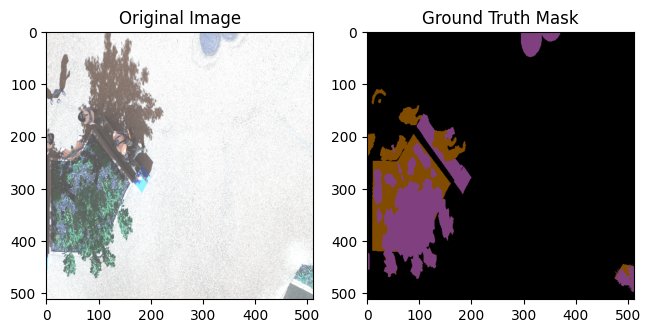

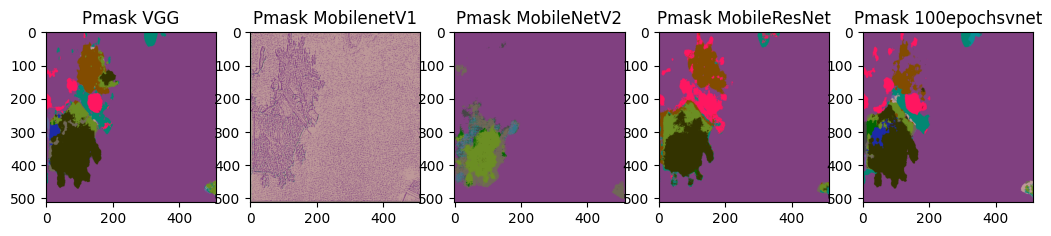

(1, 512, 512, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


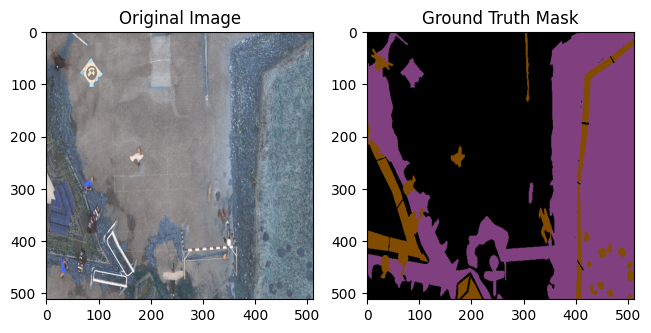

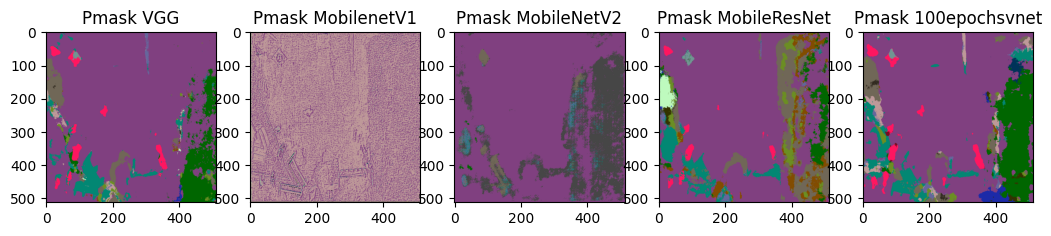

(1, 512, 512, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


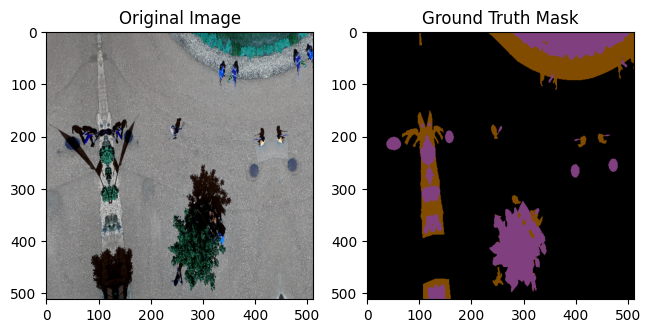

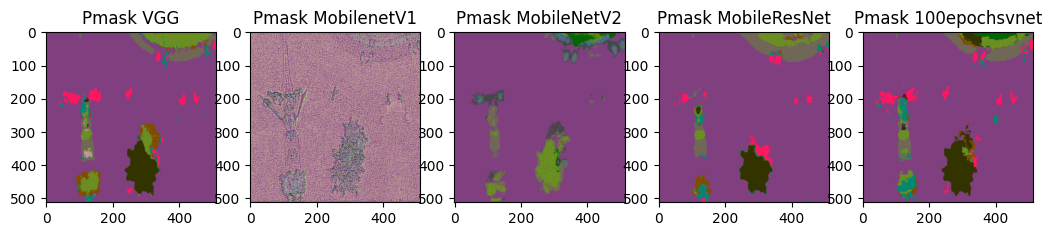

(1, 512, 512, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


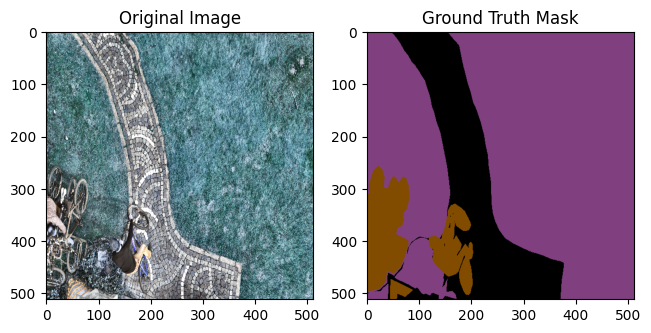

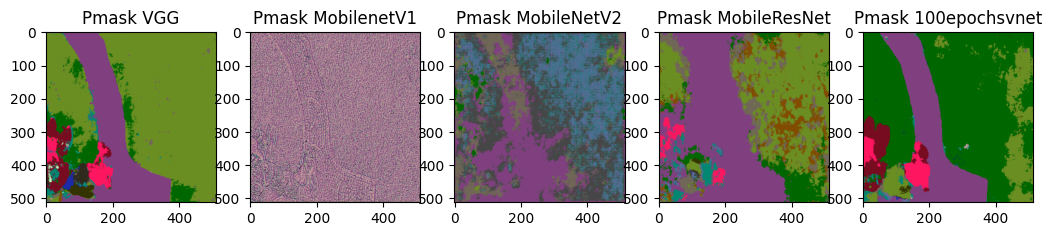

(1, 512, 512, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


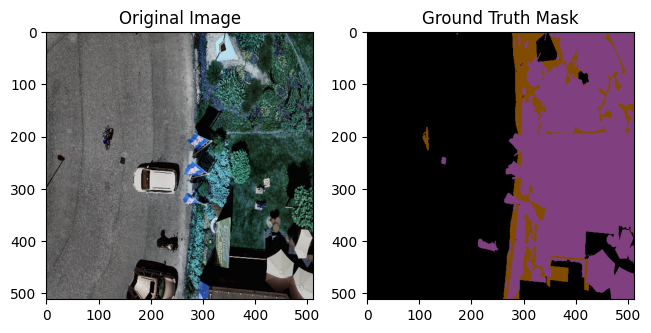

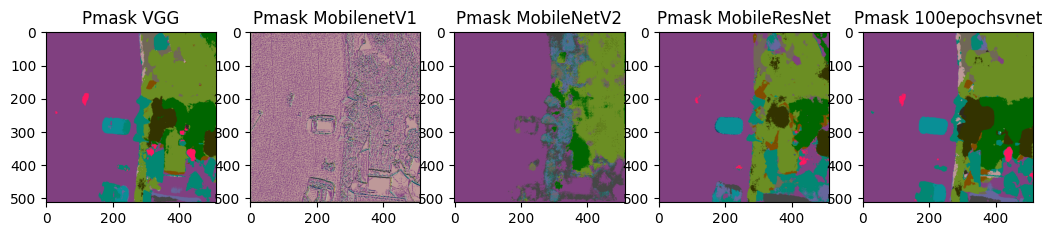

(1, 512, 512, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


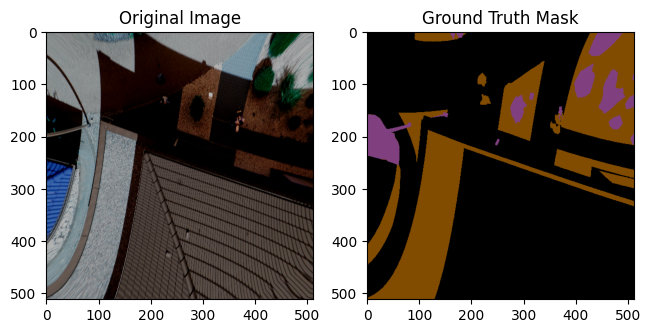

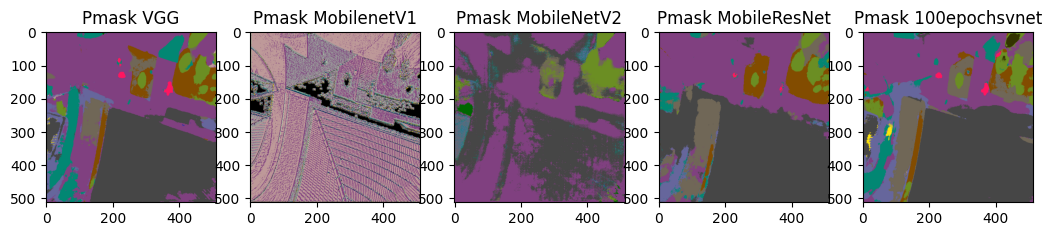

(1, 512, 512, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


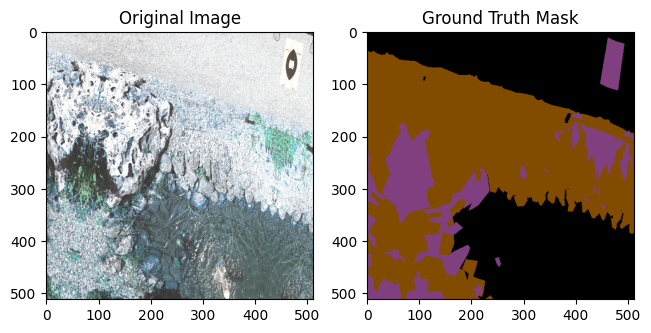

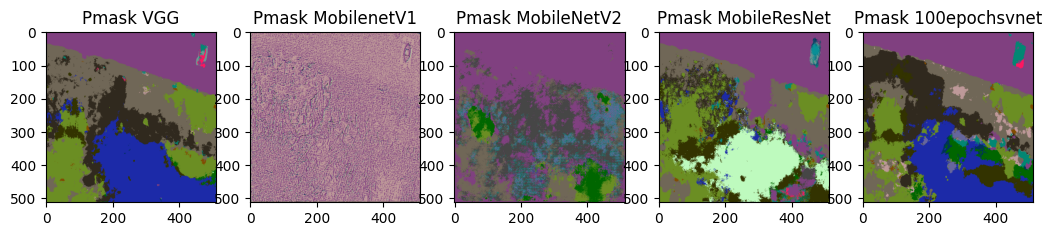

(1, 512, 512, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


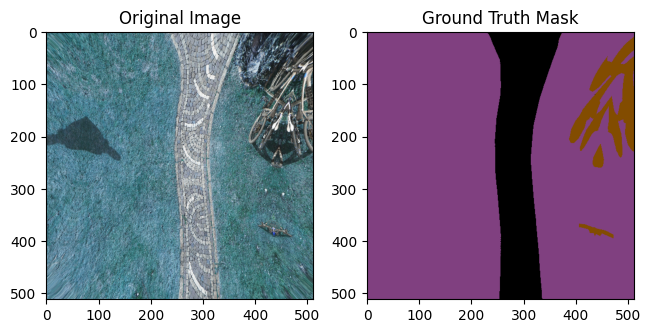

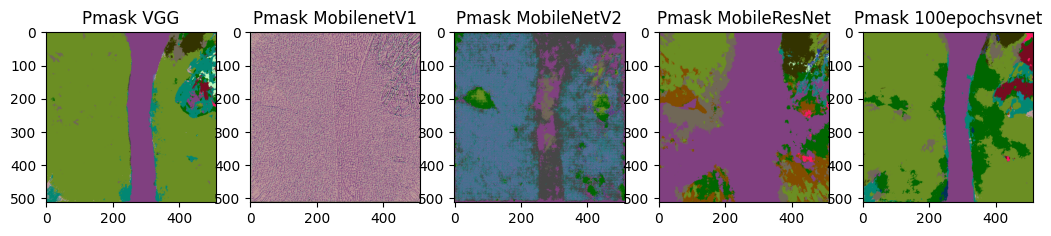

(1, 512, 512, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


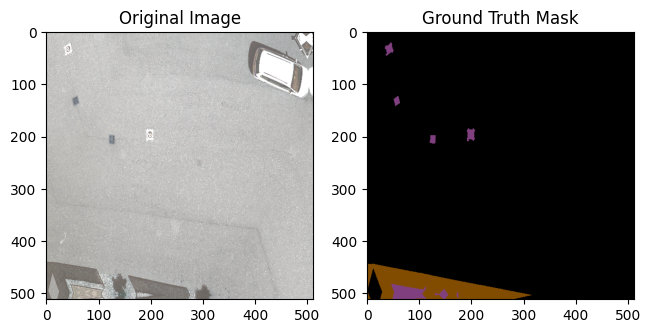

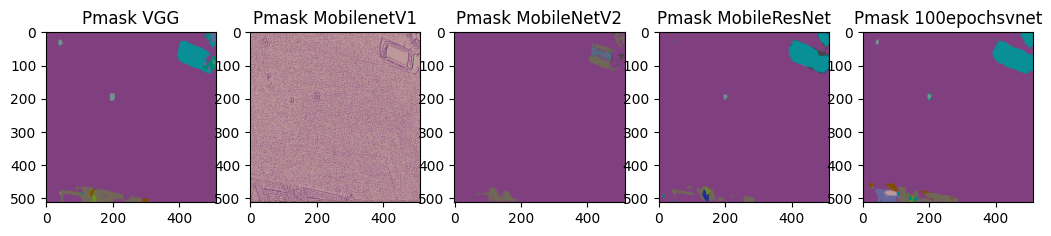

(1, 512, 512, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


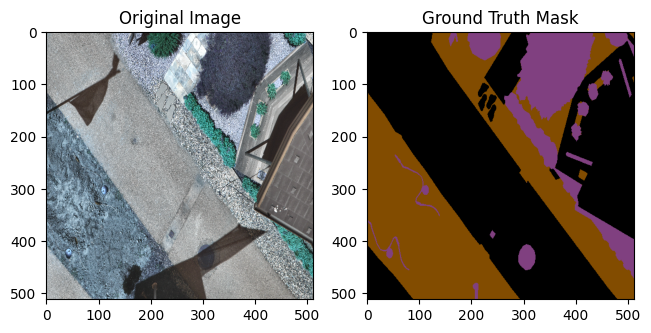

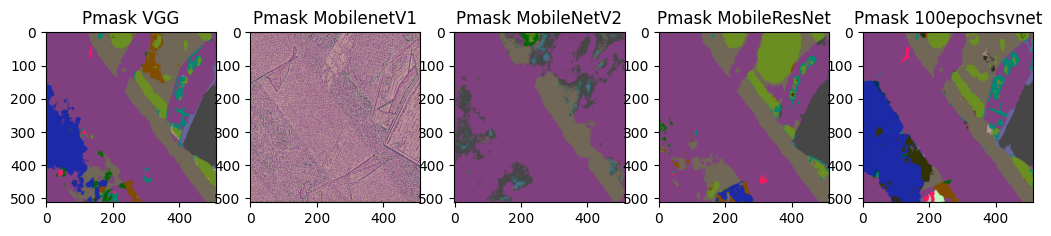

(1, 512, 512, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


KeyboardInterrupt: 

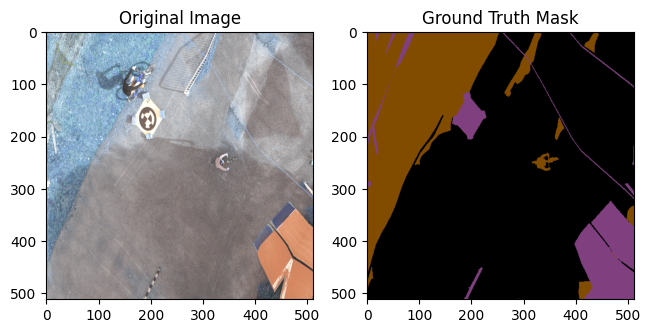

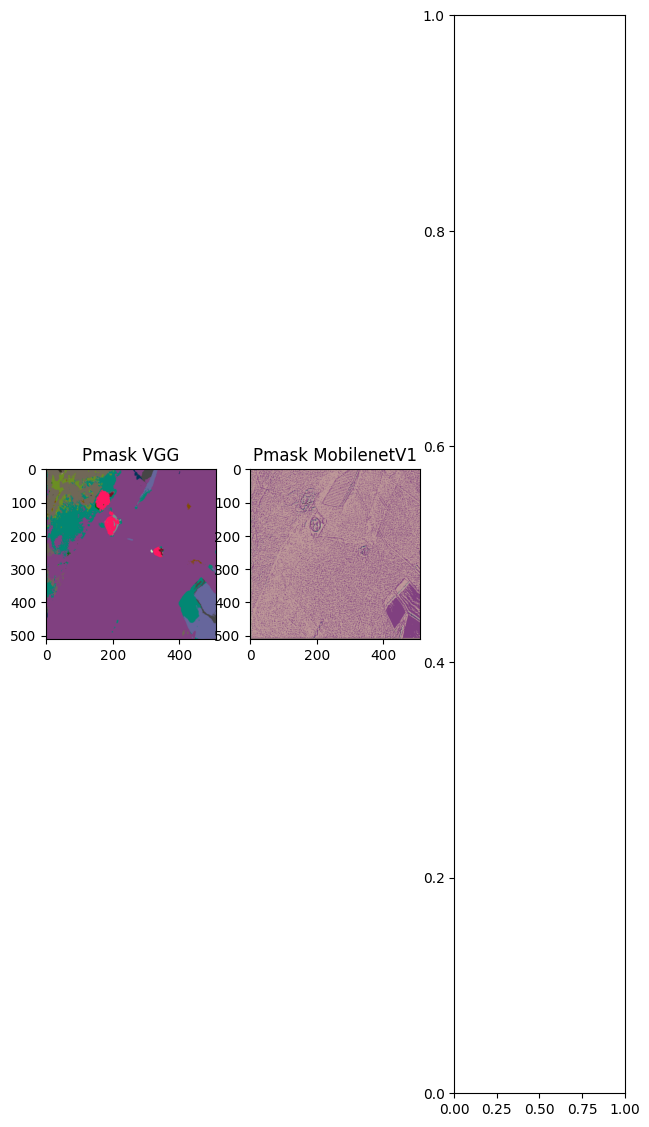

In [18]:
with tf.device('/CPU:0'):
    file_names=np.sort(os.listdir("/home/pranav/DeepLearning/semantic_drone_dataset/training_set/images"))
    file_names=np.char.split(file_names,'.')
    filenames=np.array([])
    for r in range(len(file_names)):
        filenames=np.append(filenames,file_names[r][0])
    print(filenames)    
    filenames=filenames[0:20]
    print(filenames)
    for r in range(len(filenames)):
        output(filenames[r])

['.ipynb_checkpoints' 'IMG_5969.jpg' 'IMG_5972.jpg' 'IMG_5992.jpg'
 'IMG_5993.jpg' 'IMG_6009.jpg']
['.ipynb_checkpoints' 'IMG_5969.jpg' 'IMG_5972.jpg' 'IMG_5992.jpg'
 'IMG_5993.jpg' 'IMG_6009.jpg']
['.ipynb_checkpoints' 'IMG_5969.jpg' 'IMG_5972.jpg' 'IMG_5992.jpg'
 'IMG_5993.jpg' 'IMG_6009.jpg']
File path exists.
/home/pranav/DeepLearning/PractialVision/IMG_5969.jpg
/home/pranav/DeepLearning/PractialVision/IMG_5969.jpg
(1, 512, 512, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
hhh   (256, 256, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


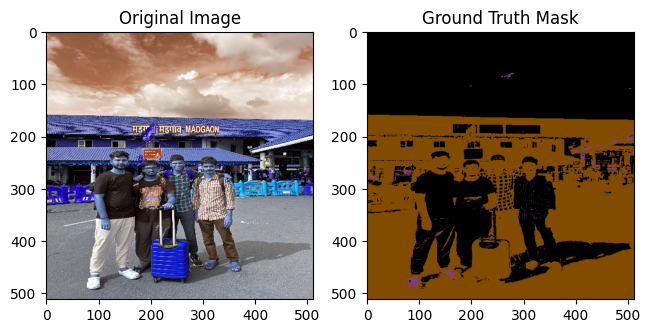

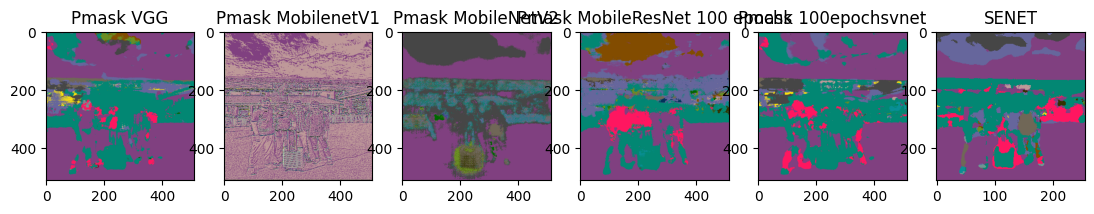

/home/pranav/DeepLearning/PractialVision/IMG_5972.jpg
(1, 512, 512, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
hhh   (256, 256, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 976ms/step


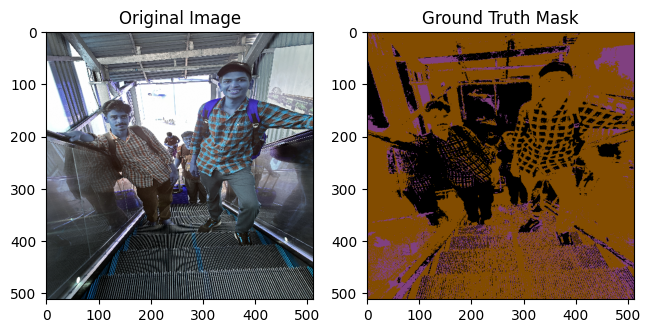

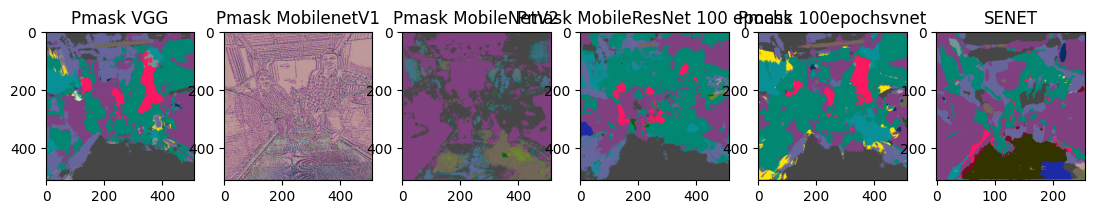

/home/pranav/DeepLearning/PractialVision/IMG_5992.jpg
(1, 512, 512, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
hhh   (256, 256, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


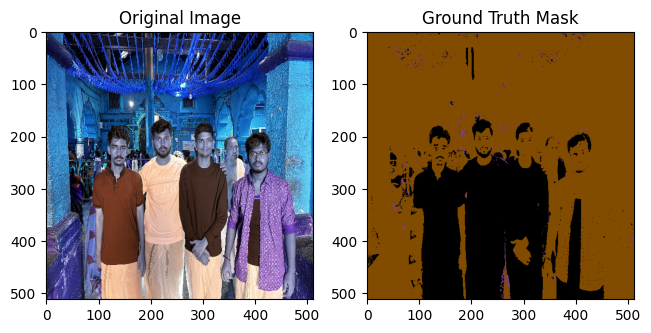

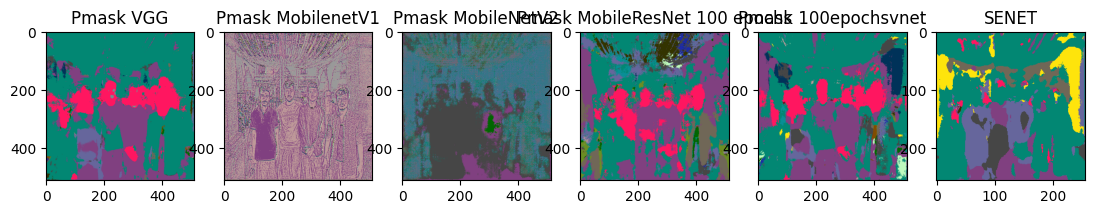

/home/pranav/DeepLearning/PractialVision/IMG_5993.jpg
(1, 512, 512, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
hhh   (256, 256, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


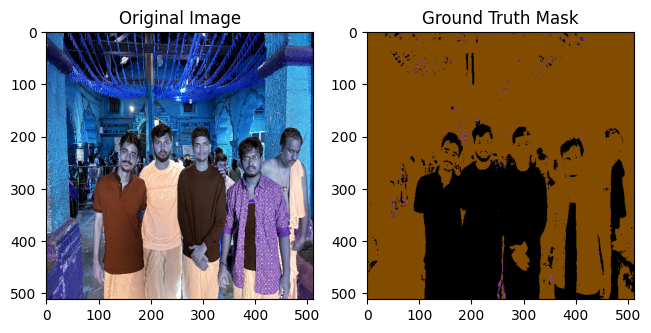

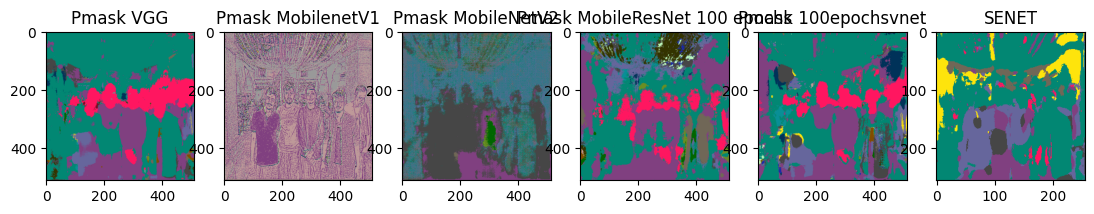

/home/pranav/DeepLearning/PractialVision/IMG_6009.jpg
(1, 512, 512, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
hhh   (256, 256, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


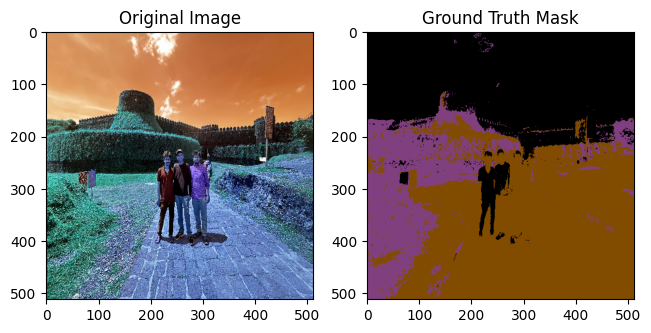

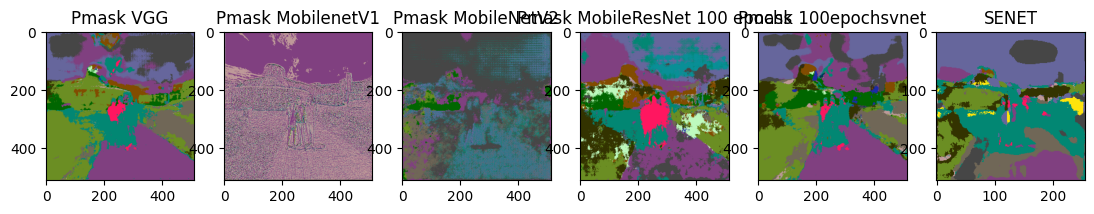

In [55]:
with tf.device('/CPU:0'):
    file_names=np.sort(os.listdir("/home/pranav/DeepLearning/PractialVision"))
    print(file_names)
    filenames=np.array([])
    for r in range(len(file_names)):
        filenames=np.append(filenames,file_names[r])
    print(filenames)    
    print(filenames)
    image_path="/home/pranav/DeepLearning/PractialVision/{}".format(filenames[1])
    if not os.path.exists(image_path):
        print("Error: File path does not exist.")
    else:
        print("File path exists.")
    print(image_path)
    img = cv2.imread(image_path)
    if img is None:
        print("hhh")
    for r in range(1,len(filenames)):
        output2(filenames[r])